In [1]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [2]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 100
Número de ecgs que eram pra ser processados: 100
Número total de traçados processados: 100


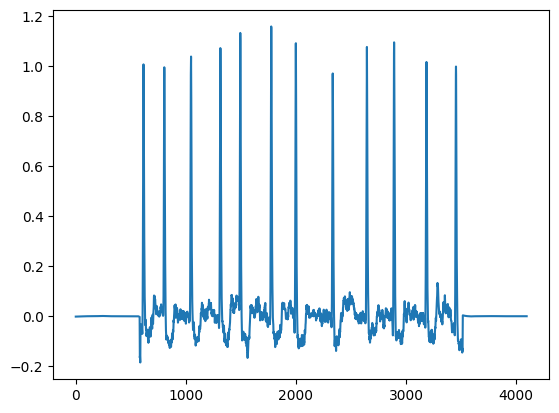

In [3]:
X = carregar_ecgs(normal=0,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=100,filtrado=True)

plt.plot(X[0][0])

/tmp/ipykernel_1153302/4291026738.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Train Dataset:
Class Distribution:
umdavb: 800
rbbb: 800
lbbb: 800
sb: 800
st: 800
af: 800
normal: 800
Validation Dataset:
Class Distribution:
umdavb: 100
rbbb: 100
lbbb: 100
sb: 100
st: 100
af: 100
normal: 100
Test Dataset:
Class Distribution:
umdavb: 100
rbbb: 100
lbbb: 100
sb: 100
st: 100
af: 100
normal: 100
Epoch 0: Train Loss = 1.8656, Val Loss = 1.7891, Val Acc = 0.3171, Weighted Val F1 = 0.2785
F1-Score for class umdavb: 0.2254
F1-Score for class rbbb: 0.4300
F1-Score for class lbbb: 0.3179
F1-Score for class sb: 0.2362
F1-Score for class st: 0.4218
F1-Score for class af: 0.0893
F1-Score for class normal: 0.2290
Epoch 1: Train Loss = 1.6445, Val Loss = 1.6352, Val Acc = 0.3914, Weighted Val F1 = 0.3528
F1-Score for class umdavb: 0.3010
F1-Score for class rbbb: 0.4815
F1-Score for class lbbb: 0.2621
F1-Score for class sb: 0.4876
F1-Score for class st: 0.6250
F1-Score for class af: 0.1732
F1-Score for class normal: 0.1391
Epoch 2: Train Loss = 1.5366, Val Loss = 1.5195, Val Acc = 

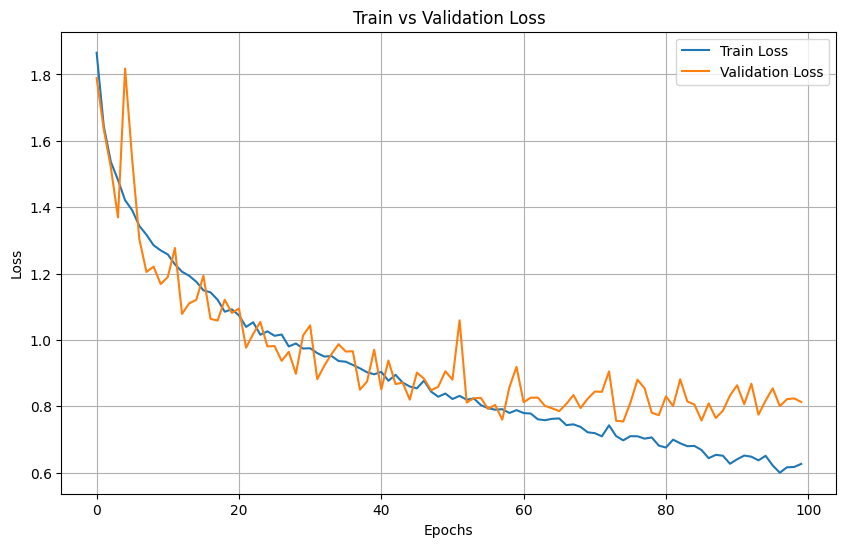

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# Lista de classes
classes = ['umdavb', 'rbbb', 'lbbb', 'sb', 'st', 'af', 'normal']
num_classes = len(classes)

from torch_geometric.nn import GINConv

class GINClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.2):
        super(GINClassifier, self).__init__()
        self.mlp1 = torch.nn.Sequential(
            torch.nn.Linear(num_features, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(self.mlp1)

        self.mlp2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(self.mlp2)

        self.mlp3 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(self.mlp3)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim * 2)
        self.bn = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.lin2 = torch.nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)

        x = self.lin1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)

        return x


class ECGVisibilityGraphsDataset(InMemoryDataset):
    def __init__(self, root, class_files, classes, transform=None, pre_transform=None):
        self.class_files = class_files
        self.classes = classes
        self._num_classes = len(classes)
        super(ECGVisibilityGraphsDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []
        for i, pt_path in enumerate(self.class_files):
            saved_data = torch.load(pt_path)
            grafos = saved_data['grafos']
            for g in grafos:
                src = g['src']
                dst = g['dst']
                features = g['features']
                num_nodes = len(features)

                # Adicionando derivada segunda como a diferença da derivada
                derivadas = [f['derivada'] for f in features]
                derivadas_segundas = [0] + [derivadas[j] - derivadas[j - 1] for j in range(1, len(derivadas))]

                x = torch.tensor([[f['amplitude'], f['derivada'], derivadas_segundas[j]] for j, f in enumerate(features)],
                                dtype=torch.float)
                edge_index = torch.stack([src, dst], dim=0)

                y = torch.tensor(i, dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

from torch.utils.data import random_split
from collections import Counter

# Função para dividir o dataset mantendo o balanceamento
def split_dataset_by_class(dataset, classes, train_ratio=0.8, val_ratio=0.1):
    class_datasets = {i: [] for i in range(len(classes))}

    # Separar exemplos por classe
    for data in dataset:
        class_datasets[data.y.item()].append(data)

    train_data = []
    val_data = []
    test_data = []

    # Dividir cada classe
    for class_idx, data_list in class_datasets.items():
        n = len(data_list)
        train_len = int(train_ratio * n)
        val_len = int(val_ratio * n)
        test_len = n - train_len - val_len

        train_subset, val_subset, test_subset = random_split(data_list, [train_len, val_len, test_len])
        train_data.extend(train_subset)
        val_data.extend(val_subset)
        test_data.extend(test_subset)

    return train_data, val_data, test_data


# Contador de classes para verificação
def count_classes(dataset, classes):
    y_counts = Counter([data.y.item() for data in dataset])
    print("Class Distribution:")
    for i, class_name in enumerate(classes):
        print(f"{class_name}: {y_counts[i]}")

if __name__ == "__main__":
    class_files = [
        'grafos/umdavb.pt',
        'grafos/rbbb.pt',
        'grafos/lbbb.pt',
        'grafos/sb.pt',
        'grafos/st.pt',
        'grafos/af.pt',
        'grafos/normal.pt'
    ]

    dataset = ECGVisibilityGraphsDataset(root='.', class_files=class_files, classes=classes)

    # Garantir balanceamento nos conjuntos
    train_dataset, val_dataset, test_dataset = split_dataset_by_class(dataset, classes)

    # Verificar o balanceamento
    print("Train Dataset:")
    count_classes(train_dataset, classes)
    print("Validation Dataset:")
    count_classes(val_dataset, classes)
    print("Test Dataset:")
    count_classes(test_dataset, classes)

    # Criar DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = GINClassifier(num_features=3, hidden_dim=128, num_classes=num_classes, dropout=0.3).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(100):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_loss += criterion(out, batch.y).item()
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc = correct / total

        val_f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        val_f1_per_class = f1_score(all_labels, all_preds, average=None)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Weighted Val F1 = {val_f1_weighted:.4f}")
        for i, class_name in enumerate(classes):
            print(f"F1-Score for class {class_name}: {val_f1_per_class[i]:.4f}")

    print("Finished training.")

    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            test_loss += criterion(out, batch.y).item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = correct / total

    test_f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    test_f1_per_class = f1_score(all_labels, all_preds, average=None)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Weighted F1: {test_f1_weighted:.4f}")
    for i, class_name in enumerate(classes):
        print(f"F1-Score for class {class_name}: {test_f1_per_class[i]:.4f}")

    print("Detailed Classification Report for Test Data:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    torch.save(model.state_dict(), "modelo_treinado.pt")

/tmp/ipykernel_1097457/511398977.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Epoch 0: Train Loss = 1.8004, Val Loss = 1.6426, Val Acc = 0.3523, Val F1 = 0.2932
Epoch 1: Train Loss = 1.7015, Val Loss = 1.6294, Val Acc = 0.3743, Val F1 = 0.3060
Epoch 2: Train Loss = 1.6903, Val Loss = 1.7265, Val Acc = 0.3304, Val F1 = 0.2624
Epoch 3: Train Loss = 1.6836, Val Loss = 1.5774, Val Acc = 0.3596, Val F1 = 0.2988
Epoch 4: Train Loss = 1.6731, Val Loss = 1.5648, Val Acc = 0.3772, Val F1 = 0.3185
Epoch 5: Train Loss = 1.6453, Val Loss = 1.5240, Val Acc = 0.4123, Val F1 = 0.3695
Epoch 6: Train Loss = 1.6051, Val Loss = 1.5125, Val Acc = 0.4240, Val F1 = 0.3833
Epoch 7: Train Loss = 1.5798, Val Loss = 1.4801, Val Acc = 0.4123, Val F1 = 0.3723
Epoch 8: Train Loss = 1.5552, Val Loss = 1.4344, Val Acc = 0.4401, Val F1 = 0.4083
Epoch 9: Train Loss = 1.5440, Val Loss = 1.4895, Val Acc = 0.4415, Val F1 = 0.3995
Epoch 10: Train Loss = 1.5246, Val Loss = 1.4052, Val Acc = 0.4444, Val F1 = 0.4279
Epoch 11: Train Loss = 1.5015, Val Loss = 1.3820, Val Acc = 0.4649, Val F1 = 0.4355
Ep

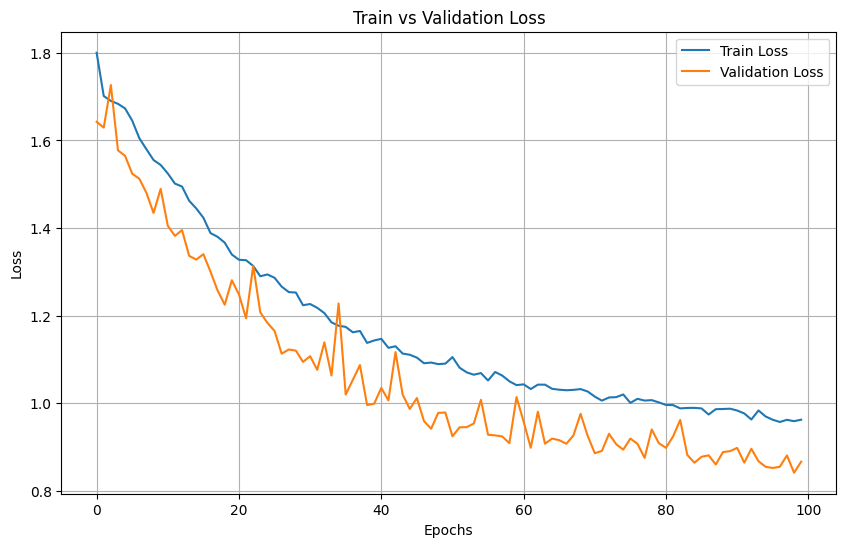

In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Lista de classes
classes = ['umdavb', 'rbbb', 'lbbb', 'sb', 'st', 'af', 'normal']
num_classes = len(classes)

class GATClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5, heads=4):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True)
        self.conv3 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)  # Final layer doesn't need concatenation
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim * 2)
        self.bn = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.lin2 = torch.nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)

        return x

# Substituindo o GCN pelo GAT no código principal
if __name__ == "__main__":
    class_files = [
        'grafos/umdavb.pt',
        'grafos/rbbb.pt',
        'grafos/lbbb.pt',
        'grafos/sb.pt',
        'grafos/st.pt',
        'grafos/af.pt',
        'grafos/normal.pt'
    ]

    dataset = ECGVisibilityGraphsDataset(root='.', class_files=class_files, classes=classes)
    dataset = dataset.shuffle()
    n = len(dataset)
    train_len = int(0.8 * n)
    val_len = int(0.1 * n)
    test_len = n - train_len - val_len

    train_dataset = dataset[:train_len]
    val_dataset = dataset[train_len:train_len+val_len]
    test_dataset = dataset[train_len+val_len:]

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = GATClassifier(num_features=2, hidden_dim=128, num_classes=num_classes, dropout=0.2, heads=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(100):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_loss += criterion(out, batch.y).item()
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc = correct / total

        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

    print("Finished training.")

    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            test_loss += criterion(out, batch.y).item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = correct / total

    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(100), train_losses, label='Train Loss')
    plt.plot(range(100), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    torch.save(model.state_dict(), "modelo_treinado_gat.pt")
